# 3. Tutorial - Advanced

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Transformations Tutorial
http://matplotlib.org/users/transforms_tutorial.html

Like any graphics packages, matplotlib is built on top of a transformation framework to easily move between coordinate systems, the userland data coordinate system, the axes coordinate system, the figure coordinate system, and the display coordinate system. In 95% of your plotting, you won’t need to think about this, as it happens under the hood, but as you push the limits of custom figure generation, it helps to have an understanding of these objects so you can reuse the existing transformations matplotlib makes available to you, or create your own (see matplotlib.transforms). The table below summarizes the existing coordinate systems, the transformation object you should use to work in that coordinate system, and the description of that system. In the Transformation Object column, ax is a ***Axes*** instance, and fig is a ***Figure*** instance.
```
Coordinate	Transformation Object	Description
data	ax.transData	The userland data coordinate system, controlled by the xlim and ylim
axes	ax.transAxes	The coordinate system of the Axes; (0,0) is bottom left of the axes, and (1,1) is top right of the axes.
figure	fig.transFigure	The coordinate system of the Figure; (0,0) is bottom left of the figure, and (1,1) is top right of the figure.
display	None	This is the pixel coordinate system of the display; (0,0) is the bottom left of the display, and (width, height) is the top right of the display in pixels. Alternatively, the identity transform (matplotlib.transforms.IdentityTransform()) may be used instead of None.
```

All of the transformation objects in the table above take inputs in their coordinate system, and transform the input to the display coordinate system. That is why the display coordinate system has None for the Transformation Object column – it already is in display coordinates. The transformations also know how to invert themselves, to go from display back to the native coordinate system. This is particularly useful when processing events from the user interface, which typically occur in display space, and you want to know where the mouse click or key-press occurred in your data coordinate system.

### Data coordinates

Let’s start with the most commonly used coordinate, the data coordinate system. Whenever you add data to the axes, matplotlib updates the datalimits, most commonly updated with the set_xlim() and set_ylim() methods. For example, in the figure below, the data limits stretch from 0 to 10 on the x-axis, and -1 to 1 on the y-axis.

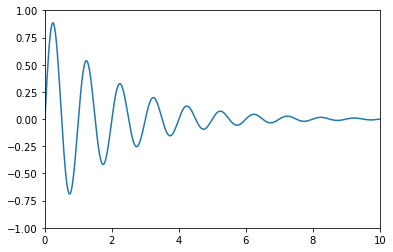

In [3]:
x = np.arange(0, 10, 0.005)
y = np.exp(-x/2.) * np.sin(2*np.pi*x)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)

plt.show()

You can use the ***ax.transData*** instance to transform from your data to your display coordinate system, either a single point or a sequence of points as shown below:

In [4]:
type(ax.transData) 

matplotlib.transforms.CompositeGenericTransform

In [5]:
ax.transData.transform((5, 0))

array([ 221.4 ,  144.72])

In [7]:
ax.transData.transform([(5, 0), (1,2)])

array([[ 221.4 ,  144.72],
       [  87.48,  362.16]])

You can use the ***inverted()*** method to create a transform which will take you from display to data coordinates:

In [8]:
inv = ax.transData.inverted()

In [9]:
type(inv)

matplotlib.transforms.CompositeGenericTransform

In [10]:
inv.transform((335.175,  247.))

array([ 8.39829749,  0.94076527])

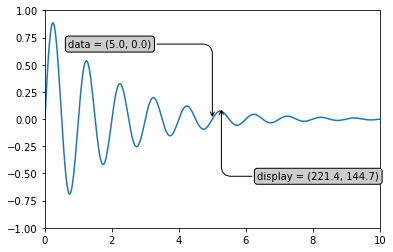

In [11]:
x = np.arange(0, 10, 0.005)
y = np.exp(-x/2.) * np.sin(2*np.pi*x)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)

xdata, ydata = 5, 0
xdisplay, ydisplay = ax.transData.transform_point((xdata, ydata))

bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "->",
    connectionstyle = "angle,angleA=0,angleB=90,rad=10")

offset = 72
ax.annotate('data = (%.1f, %.1f)'%(xdata, ydata),
            (xdata, ydata), xytext=(-2*offset, offset), textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)


disp = ax.annotate('display = (%.1f, %.1f)'%(xdisplay, ydisplay),
            (xdisplay, ydisplay), xytext=(0.5*offset, -offset),
            xycoords='figure pixels',
            textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)


plt.show()

When you change the x or y limits of your axes, the data limits are updated so the transformation yields a new display point. Note that when we just change the ylim, only the y-display coordinate is altered, and when we change the xlim too, both are altered. More on this later when we talk about the Bbox.

In [12]:
ax.transData.transform((5, 0))

array([ 221.4 ,  144.72])

In [13]:
ax.set_ylim(-1,2)
ax.transData.transform((5, 0))

array([ 221.4 ,  108.48])

In [14]:
ax.set_xlim(10,20)
ax.transData.transform((5, 0))

array([-113.4 ,  108.48])

### Axes coordinates

After the data coordinate system, axes is probably the second most useful coordinate system. Here the point (0,0) is the bottom left of your axes or subplot, (0.5, 0.5) is the center, and (1.0, 1.0) is the top right. You can also refer to points outside the range, so (-0.1, 1.1) is to the left and above your axes. This coordinate system is extremely useful when placing text in your axes, because you often want a text bubble in a fixed, location, e.g., the upper left of the axes pane, and have that location remain fixed when you pan or zoom. Here is a simple example that creates four panels and labels them ‘A’, ‘B’, ‘C’, ‘D’ as you often see in journals.

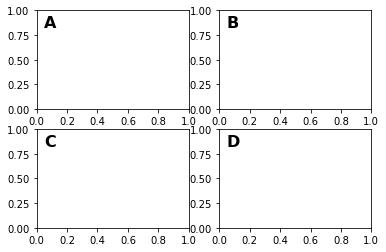

In [15]:
fig = plt.figure()
for i, label in enumerate(('A', 'B', 'C', 'D')):
    ax = fig.add_subplot(2,2,i+1)
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top')

plt.show()

You can also make lines or patches in the axes coordinate system, but this is less useful in my experience than using ax.transAxes for placing text. Nonetheless, here is a silly example which plots some random dots in data space, and overlays a semi-transparent Circle centered in the middle of the axes with a radius one quarter of the axes – if your axes does not preserve aspect ratio (see set_aspect()), this will look like an ellipse. Use the pan/zoom tool to move around, or manually change the data xlim and ylim, and you will see the data move, but the circle will remain fixed because it is not in data coordinates and will always remain at the center of the axes.

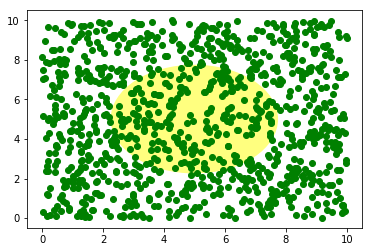

In [16]:
import matplotlib.patches as patches
fig = plt.figure()
ax = fig.add_subplot(111)
x, y = 10*np.random.rand(2, 1000)
ax.plot(x, y, 'go')  # plot some data in data coordinates

circ = patches.Circle((0.5, 0.5), 0.25, transform=ax.transAxes,
                      facecolor='yellow', alpha=0.5)
ax.add_patch(circ)

plt.show()

### Blended transformations

Drawing in blended coordinate spaces which mix axes with data coordinates is extremely useful, for example to create a horizontal span which highlights some region of the y-data but spans across the x-axis regardless of the data limits, pan or zoom level, etc. In fact these blended lines and spans are so useful, we have built in functions to make them easy to plot (see ***axhline(), axvline(), axhspan(), axvspan()***) but for didactic purposes we will implement the horizontal span here using a blended transformation. This trick only works for separable transformations, like you see in normal Cartesian coordinate systems, but not on inseparable transformations like the PolarTransform.

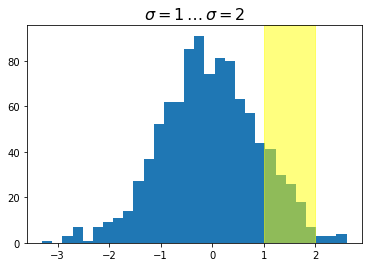

In [20]:
import matplotlib.patches as patches
import matplotlib.transforms as transforms

fig = plt.figure()
ax = fig.add_subplot(111)

x = np.random.randn(1000)

ax.hist(x, 30)
ax.set_title(r'$\sigma=1 \/ \dots \/ \sigma=2$', fontsize=16)

# the x coords of this transformation are data, and the
# y coord are axes
# trans = transforms.blended_transform_factory(
#     ax.transData, ax.transAxes)
trans = ax.get_xaxis_transform()

# highlight the 1..2 stddev region with a span.
# We want x to be in data coordinates and y to
# span from 0..1 in axes coords
rect = patches.Rectangle((1,0), width=1, height=1,
                         transform=trans, color='yellow',
                         alpha=0.5)

ax.add_patch(rect)

plt.show()

#### Note:  
The blended transformations where x is in data coords and y in axes coordinates is so useful that we have helper methods to return the versions mpl uses internally for drawing ticks, ticklabels, etc. The methods are matplotlib.axes.Axes.get_xaxis_transform() and matplotlib.axes.Axes.get_yaxis_transform(). So in the example above, the call to blended_transform_factory() can be replaced by get_xaxis_transform:
> trans = ax.get_xaxis_transform()

## Using offset transforms to create a shadow effect

One use of transformations is to create a new transformation that is offset from another transformation, e.g., to place one object shifted a bit relative to another object. Typically you want the shift to be in some physical dimension, like points or inches rather than in data coordinates, so that the shift effect is constant at different zoom levels and dpi settings.

One use for an offset is to create a shadow effect, where you draw one object identical to the first just to the right of it, and just below it, adjusting the zorder to make sure the shadow is drawn first and then the object it is shadowing above it. The transforms module has a helper transformation ***ScaledTranslation***. It is instantiated with:
> trans = ScaledTranslation(xt, yt, scale_trans)  

where xt and yt are the translation offsets, and scale_trans is a transformation which scales xt and yt at transformation time before applying the offsets. A typical use case is to use the figure fig.dpi_scale_trans transformation for the scale_trans argument, to first scale xt and yt specified in points to display space before doing the final offset. The dpi and inches offset is a common-enough use case that we have a special helper function to create it in matplotlib.transforms.offset_copy(), which returns a new transform with an added offset. But in the example below, we’ll create the offset transform ourselves. Note the use of the plus operator in:  
> offset = transforms.ScaledTranslation(dx, dy,
  fig.dpi_scale_trans)
shadow_transform = ax.transData + offset

showing that can chain transformations using the addition operator. This code says: first apply the data transformation ax.transData and then translate the data by dx and dy points. In typography, a`point <https://en.wikipedia.org/wiki/Point_%28typography%29>`_ is 1/72 inches, and by specifying your offsets in points, your figure will look the same regardless of the dpi resolution it is saved in.

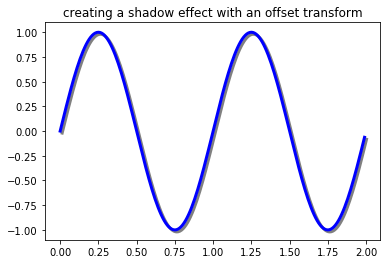

In [21]:
import matplotlib.patches as patches
import matplotlib.transforms as transforms

fig = plt.figure()
ax = fig.add_subplot(111)

# make a simple sine wave
x = np.arange(0., 2., 0.01)
y = np.sin(2*np.pi*x)
line, = ax.plot(x, y, lw=3, color='blue')

# shift the object over 2 points, and down 2 points
dx, dy = 2/72., -2/72.
offset = transforms.ScaledTranslation(dx, dy,
  fig.dpi_scale_trans)
shadow_transform = ax.transData + offset

# now plot the same data with our offset transform;
# use the zorder to make sure we are below the line
ax.plot(x, y, lw=3, color='gray',
  transform=shadow_transform,
  zorder=0.5*line.get_zorder())

ax.set_title('creating a shadow effect with an offset transform')
plt.show()

## The transformation pipeline

The ax.transData transform we have been working with in this tutorial is a composite of three different transformations that comprise the transformation pipeline from data -> display coordinates. Michael Droettboom implemented the transformations framework, taking care to provide a clean API that segregated the nonlinear projections and scales that happen in polar and logarithmic plots, from the linear affine transformations that happen when you pan and zoom. There is an efficiency here, because you can pan and zoom in your axes which affects the affine transformation, but you may not need to compute the potentially expensive nonlinear scales or projections on simple navigation events. It is also possible to multiply affine transformation matrices together, and then apply them to coordinates in one step. This is not true of all possible transformations.

Here is how the ax.transData instance is defined in the basic separable axis Axes class:

> self.transData = self.transScale + (self.transLimits + self.transAxes)  

We’ve been introduced to the transAxes instance above in Axes coordinates, which maps the (0,0), (1,1) corners of the axes or subplot bounding box to display space, so let’s look at these other two pieces.

***self.transLimits*** is the transformation that takes you from data to axes coordinates; i.e., it maps your view xlim and ylim to the unit space of the axes (and transAxes then takes that unit space to display space). We can see this in action here

array([ 0.,  0.])

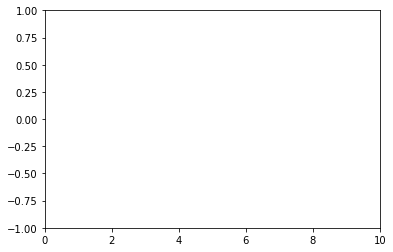

In [25]:
ax = subplot(111)
ax.set_xlim(0, 10)
ax.set_ylim(-1,1)
ax.transLimits.transform((0,-1))

In [26]:
ax.transLimits.transform((10,-1))

array([ 1.,  0.])

In [27]:
ax.transLimits.transform((10,1))

array([ 1.,  1.])

In [28]:
ax.transLimits.transform((5,0))

array([ 0.5,  0.5])

and we can use this same inverted transformation to go from the unit axes coordinates back to data coordinates.

In [33]:
inv = ax.transLimits.inverted()
inv.transform((0.25, 0.25))

array([ 2.5, -0.5])

The final piece is the ***self.transScale*** attribute, which is responsible for the optional non-linear scaling of the data, e.g., for logarithmic axes. When an Axes is initially setup, this is just set to the identity transform, since the basic matplotlib axes has linear scale, but when you call a logarithmic scaling function like ***semilogx()*** or explicitly set the scale to logarithmic with ***set_xscale()***, then the ***ax.transScale*** attribute is set to handle the nonlinear projection. The scales transforms are properties of the respective xaxis and yaxis Axis instances. For example, when you call ***ax.set_xscale('log')***, the xaxis updates its scale to a ***matplotlib.scale.LogScale*** instance.

For non-separable axes the PolarAxes, there is one more piece to consider, the ***projection transformation***. The ***transData matplotlib.projections.polar.PolarAxes*** is similar to that for the typical separable matplotlib Axes, with one additional piece transProjection:

> self.transData = self.transScale + self.transProjection +                                          self.transProjectionAffine + self.transAxes)
    
transProjection handles the projection from the space, e.g., latitude and longitude for map data, or radius and theta for polar data, to a separable Cartesian coordinate system. There are several projection examples in the ***matplotlib.projections*** package, and the best way to learn more is to open the source for those packages and see how to make your own, since matplotlib supports extensible axes and projections. Michael Droettboom has provided a nice tutorial example of creating a hammer projection axes; see api example code: custom_projection_example.py.

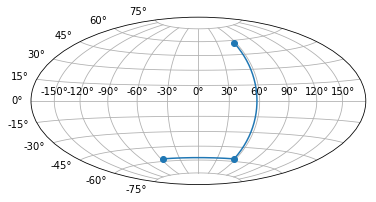

In [34]:
from matplotlib.axes import Axes
from matplotlib.patches import Circle
from matplotlib.path import Path
from matplotlib.ticker import NullLocator, Formatter, FixedLocator
from matplotlib.transforms import Affine2D, BboxTransformTo, Transform
from matplotlib.projections import register_projection
import matplotlib.spines as mspines
import matplotlib.axis as maxis
import numpy as np

rcParams = matplotlib.rcParams

# This example projection class is rather long, but it is designed to
# illustrate many features, not all of which will be used every time.
# It is also common to factor out a lot of these methods into common
# code used by a number of projections with similar characteristics
# (see geo.py).


class GeoAxes(Axes):
    """
    An abstract base class for geographic projections
    """
    class ThetaFormatter(Formatter):
        """
        Used to format the theta tick labels.  Converts the native
        unit of radians into degrees and adds a degree symbol.
        """
        def __init__(self, round_to=1.0):
            self._round_to = round_to

        def __call__(self, x, pos=None):
            degrees = (x / np.pi) * 180.0
            degrees = np.round(degrees / self._round_to) * self._round_to
            if rcParams['text.usetex'] and not rcParams['text.latex.unicode']:
                return r"$%0.0f^\circ$" % degrees
            else:
                return "%0.0f\u00b0" % degrees

    RESOLUTION = 75

    def _init_axis(self):
        self.xaxis = maxis.XAxis(self)
        self.yaxis = maxis.YAxis(self)
        # Do not register xaxis or yaxis with spines -- as done in
        # Axes._init_axis() -- until GeoAxes.xaxis.cla() works.
        # self.spines['geo'].register_axis(self.yaxis)
        self._update_transScale()

    def cla(self):
        Axes.cla(self)

        self.set_longitude_grid(30)
        self.set_latitude_grid(15)
        self.set_longitude_grid_ends(75)
        self.xaxis.set_minor_locator(NullLocator())
        self.yaxis.set_minor_locator(NullLocator())
        self.xaxis.set_ticks_position('none')
        self.yaxis.set_ticks_position('none')
        self.yaxis.set_tick_params(label1On=True)
        # Why do we need to turn on yaxis tick labels, but
        # xaxis tick labels are already on?

        self.grid(rcParams['axes.grid'])

        Axes.set_xlim(self, -np.pi, np.pi)
        Axes.set_ylim(self, -np.pi / 2.0, np.pi / 2.0)

    def _set_lim_and_transforms(self):
        # A (possibly non-linear) projection on the (already scaled) data

        # There are three important coordinate spaces going on here:
        #
        #    1. Data space: The space of the data itself
        #
        #    2. Axes space: The unit rectangle (0, 0) to (1, 1)
        #       covering the entire plot area.
        #
        #    3. Display space: The coordinates of the resulting image,
        #       often in pixels or dpi/inch.

        # This function makes heavy use of the Transform classes in
        # ``lib/matplotlib/transforms.py.`` For more information, see
        # the inline documentation there.

        # The goal of the first two transformations is to get from the
        # data space (in this case longitude and latitude) to axes
        # space.  It is separated into a non-affine and affine part so
        # that the non-affine part does not have to be recomputed when
        # a simple affine change to the figure has been made (such as
        # resizing the window or changing the dpi).

        # 1) The core transformation from data space into
        # rectilinear space defined in the HammerTransform class.
        self.transProjection = self._get_core_transform(self.RESOLUTION)

        # 2) The above has an output range that is not in the unit
        # rectangle, so scale and translate it so it fits correctly
        # within the axes.  The peculiar calculations of xscale and
        # yscale are specific to a Aitoff-Hammer projection, so don't
        # worry about them too much.
        self.transAffine = self._get_affine_transform()

        # 3) This is the transformation from axes space to display
        # space.
        self.transAxes = BboxTransformTo(self.bbox)

        # Now put these 3 transforms together -- from data all the way
        # to display coordinates.  Using the '+' operator, these
        # transforms will be applied "in order".  The transforms are
        # automatically simplified, if possible, by the underlying
        # transformation framework.
        self.transData = \
            self.transProjection + \
            self.transAffine + \
            self.transAxes

        # The main data transformation is set up.  Now deal with
        # gridlines and tick labels.

        # Longitude gridlines and ticklabels.  The input to these
        # transforms are in display space in x and axes space in y.
        # Therefore, the input values will be in range (-xmin, 0),
        # (xmax, 1).  The goal of these transforms is to go from that
        # space to display space.  The tick labels will be offset 4
        # pixels from the equator.
        self._xaxis_pretransform = \
            Affine2D() \
            .scale(1.0, self._longitude_cap * 2.0) \
            .translate(0.0, -self._longitude_cap)
        self._xaxis_transform = \
            self._xaxis_pretransform + \
            self.transData
        self._xaxis_text1_transform = \
            Affine2D().scale(1.0, 0.0) + \
            self.transData + \
            Affine2D().translate(0.0, 4.0)
        self._xaxis_text2_transform = \
            Affine2D().scale(1.0, 0.0) + \
            self.transData + \
            Affine2D().translate(0.0, -4.0)

        # Now set up the transforms for the latitude ticks.  The input to
        # these transforms are in axes space in x and display space in
        # y.  Therefore, the input values will be in range (0, -ymin),
        # (1, ymax).  The goal of these transforms is to go from that
        # space to display space.  The tick labels will be offset 4
        # pixels from the edge of the axes ellipse.
        yaxis_stretch = Affine2D().scale(np.pi*2, 1).translate(-np.pi, 0)
        yaxis_space = Affine2D().scale(1.0, 1.1)
        self._yaxis_transform = \
            yaxis_stretch + \
            self.transData
        yaxis_text_base = \
            yaxis_stretch + \
            self.transProjection + \
            (yaxis_space +
             self.transAffine +
             self.transAxes)
        self._yaxis_text1_transform = \
            yaxis_text_base + \
            Affine2D().translate(-8.0, 0.0)
        self._yaxis_text2_transform = \
            yaxis_text_base + \
            Affine2D().translate(8.0, 0.0)

    def _get_affine_transform(self):
        transform = self._get_core_transform(1)
        xscale, _ = transform.transform_point((np.pi, 0))
        _, yscale = transform.transform_point((0, np.pi / 2.0))
        return Affine2D() \
            .scale(0.5 / xscale, 0.5 / yscale) \
            .translate(0.5, 0.5)

    def get_xaxis_transform(self, which='grid'):
        """
        Override this method to provide a transformation for the
        x-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        if which not in ['tick1', 'tick2', 'grid']:
            msg = "'which' must be on of [ 'tick1' | 'tick2' | 'grid' ]"
            raise ValueError(msg)
        return self._xaxis_transform

    def get_xaxis_text1_transform(self, pad):
        return self._xaxis_text1_transform, 'bottom', 'center'

    def get_xaxis_text2_transform(self, pad):
        """
        Override this method to provide a transformation for the
        secondary x-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._xaxis_text2_transform, 'top', 'center'

    def get_yaxis_transform(self, which='grid'):
        """
        Override this method to provide a transformation for the
        y-axis grid and ticks.
        """
        if which not in ['tick1', 'tick2', 'grid']:
            msg = "'which' must be one of [ 'tick1' | 'tick2' | 'grid' ]"
            raise ValueError(msg)
        return self._yaxis_transform

    def get_yaxis_text1_transform(self, pad):
        """
        Override this method to provide a transformation for the
        y-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._yaxis_text1_transform, 'center', 'right'

    def get_yaxis_text2_transform(self, pad):
        """
        Override this method to provide a transformation for the
        secondary y-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._yaxis_text2_transform, 'center', 'left'

    def _gen_axes_patch(self):
        """
        Override this method to define the shape that is used for the
        background of the plot.  It should be a subclass of Patch.

        In this case, it is a Circle (that may be warped by the axes
        transform into an ellipse).  Any data and gridlines will be
        clipped to this shape.
        """
        return Circle((0.5, 0.5), 0.5)

    def _gen_axes_spines(self):
        return {'geo': mspines.Spine.circular_spine(self, (0.5, 0.5), 0.5)}

    def set_yscale(self, *args, **kwargs):
        if args[0] != 'linear':
            raise NotImplementedError

    # Prevent the user from applying scales to one or both of the
    # axes.  In this particular case, scaling the axes wouldn't make
    # sense, so we don't allow it.
    set_xscale = set_yscale

    # Prevent the user from changing the axes limits.  In our case, we
    # want to display the whole sphere all the time, so we override
    # set_xlim and set_ylim to ignore any input.  This also applies to
    # interactive panning and zooming in the GUI interfaces.
    def set_xlim(self, *args, **kwargs):
        raise TypeError("It is not possible to change axes limits "
                        "for geographic projections. Please consider "
                        "using Basemap or Cartopy.")

    set_ylim = set_xlim

    def format_coord(self, lon, lat):
        """
        Override this method to change how the values are displayed in
        the status bar.

        In this case, we want them to be displayed in degrees N/S/E/W.
        """
        lon = lon * (180.0 / np.pi)
        lat = lat * (180.0 / np.pi)
        if lat >= 0.0:
            ns = 'N'
        else:
            ns = 'S'
        if lon >= 0.0:
            ew = 'E'
        else:
            ew = 'W'
        return '%f\u00b0%s, %f\u00b0%s' % (abs(lat), ns, abs(lon), ew)

    def set_longitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.

        This is an example method that is specific to this projection
        class -- it provides a more convenient interface to set the
        ticking than set_xticks would.
        """
        number = (360.0 / degrees) + 1
        self.xaxis.set_major_locator(
            FixedLocator(
                np.linspace(-np.pi, np.pi, number, True)[1:-1]))
        self.xaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def set_latitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.

        This is an example method that is specific to this projection
        class -- it provides a more convenient interface than
        set_yticks would.
        """
        number = (180.0 / degrees) + 1
        self.yaxis.set_major_locator(
            FixedLocator(
                np.linspace(-np.pi / 2.0, np.pi / 2.0, number, True)[1:-1]))
        self.yaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def set_longitude_grid_ends(self, degrees):
        """
        Set the latitude(s) at which to stop drawing the longitude grids.

        Often, in geographic projections, you wouldn't want to draw
        longitude gridlines near the poles.  This allows the user to
        specify the degree at which to stop drawing longitude grids.

        This is an example method that is specific to this projection
        class -- it provides an interface to something that has no
        analogy in the base Axes class.
        """
        self._longitude_cap = degrees * (np.pi / 180.0)
        self._xaxis_pretransform \
            .clear() \
            .scale(1.0, self._longitude_cap * 2.0) \
            .translate(0.0, -self._longitude_cap)

    def get_data_ratio(self):
        """
        Return the aspect ratio of the data itself.

        This method should be overridden by any Axes that have a
        fixed data ratio.
        """
        return 1.0

    # Interactive panning and zooming is not supported with this projection,
    # so we override all of the following methods to disable it.
    def can_zoom(self):
        """
        Return *True* if this axes supports the zoom box button functionality.
        This axes object does not support interactive zoom box.
        """
        return False

    def can_pan(self):
        """
        Return *True* if this axes supports the pan/zoom button functionality.
        This axes object does not support interactive pan/zoom.
        """
        return False

    def start_pan(self, x, y, button):
        pass

    def end_pan(self):
        pass

    def drag_pan(self, button, key, x, y):
        pass


class HammerAxes(GeoAxes):
    """
    A custom class for the Aitoff-Hammer projection, an equal-area map
    projection.

    https://en.wikipedia.org/wiki/Hammer_projection
    """

    # The projection must specify a name. This will be used by the
    # user to select the projection,
    # i.e. ``subplot(111, projection='custom_hammer')``.
    name = 'custom_hammer'

    class HammerTransform(Transform):
        """
        The base Hammer transform.
        """
        input_dims = 2
        output_dims = 2
        is_separable = False

        def __init__(self, resolution):
            """
            Create a new Hammer transform.  Resolution is the number of steps
            to interpolate between each input line segment to approximate its
            path in curved Hammer space.
            """
            Transform.__init__(self)
            self._resolution = resolution

        def transform_non_affine(self, ll):
            longitude = ll[:, 0:1]
            latitude = ll[:, 1:2]

            # Pre-compute some values
            half_long = longitude / 2.0
            cos_latitude = np.cos(latitude)
            sqrt2 = np.sqrt(2.0)

            alpha = np.sqrt(1.0 + cos_latitude * np.cos(half_long))
            x = (2.0 * sqrt2) * (cos_latitude * np.sin(half_long)) / alpha
            y = (sqrt2 * np.sin(latitude)) / alpha
            return np.concatenate((x, y), 1)
        transform_non_affine.__doc__ = Transform.transform_non_affine.__doc__

        def transform_path_non_affine(self, path):
            # vertices = path.vertices
            ipath = path.interpolated(self._resolution)
            return Path(self.transform(ipath.vertices), ipath.codes)
        transform_path_non_affine.__doc__ = \
            Transform.transform_path_non_affine.__doc__

        def inverted(self):
            return HammerAxes.InvertedHammerTransform(self._resolution)
        inverted.__doc__ = Transform.inverted.__doc__

    class InvertedHammerTransform(Transform):
        input_dims = 2
        output_dims = 2
        is_separable = False

        def __init__(self, resolution):
            Transform.__init__(self)
            self._resolution = resolution

        def transform_non_affine(self, xy):
            x = xy[:, 0:1]
            y = xy[:, 1:2]

            quarter_x = 0.25 * x
            half_y = 0.5 * y
            z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)
            longitude = 2 * np.arctan((z*x) / (2.0 * (2.0*z*z - 1.0)))
            latitude = np.arcsin(y*z)
            return np.concatenate((longitude, latitude), 1)
        transform_non_affine.__doc__ = Transform.transform_non_affine.__doc__

        def inverted(self):
            return HammerAxes.HammerTransform(self._resolution)
        inverted.__doc__ = Transform.inverted.__doc__

    def __init__(self, *args, **kwargs):
        self._longitude_cap = np.pi / 2.0
        GeoAxes.__init__(self, *args, **kwargs)
        self.set_aspect(0.5, adjustable='box', anchor='C')
        self.cla()

    def _get_core_transform(self, resolution):
        return self.HammerTransform(resolution)


# Now register the projection with matplotlib so the user can select
# it.
register_projection(HammerAxes)


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    # Now make a simple example using the custom projection.
    plt.subplot(111, projection="custom_hammer")
    p = plt.plot([-1, 1, 1], [-1, -1, 1], "o-")
    plt.grid(True)

    plt.show()

## Path Tutorial
http://matplotlib.org/users/path_tutorial.html

The object underlying all of the ***matplotlib.patch*** objects is the ***Path***, which supports the standard set of moveto, lineto, curveto commands to draw simple and compound outlines consisting of line segments and splines. The Path is instantiated with a (N,2) array of (x,y) vertices, and a N-length array of path codes. For example to draw the unit rectangle from (0,0) to (1,1), we could use this code

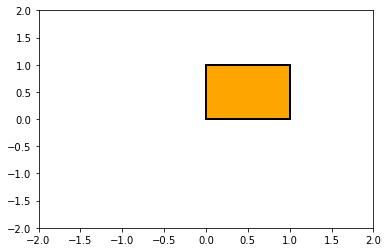

In [35]:
from matplotlib.path import Path
import matplotlib.patches as patches

verts = [
    (0., 0.), # left, bottom
    (0., 1.), # left, top
    (1., 1.), # right, top
    (1., 0.), # right, bottom
    (0., 0.), # ignored
    ]

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

fig = plt.figure()
ax = fig.add_subplot(111)

path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.show()

The following path codes are recognized
```
Code	Vertices	Description
STOP	1 (ignored)	A marker for the end of the entire path (currently not required and ignored)
MOVETO	1	Pick up the pen and move to the given vertex.
LINETO	1	Draw a line from the current position to the given vertex.
CURVE3	2 (1 control point, 1 endpoint)	Draw a quadratic Bézier curve from the current position, with the given control point, to the given end point.
CURVE4	3 (2 control points, 1 endpoint)	Draw a cubic Bézier curve from the current position, with the given control points, to the given end point.
CLOSEPOLY	1 (point itself is ignored)	Draw a line segment to the start point of the current polyline.
```

### Bézier example

Some of the path components require multiple vertices to specify them: for example CURVE 3 is a bézier curve with one control point and one end point, and CURVE4 has three vertices for the two control points and the end point. The example below shows a CURVE4 Bézier spline – the bézier curve will be contained in the convex hull of the start point, the two control points, and the end point

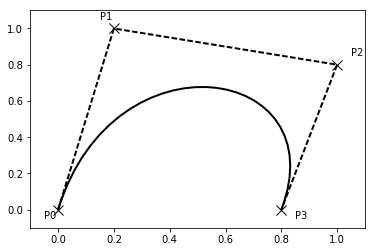

In [36]:
from matplotlib.path import Path
import matplotlib.patches as patches

verts = [
    (0., 0.),  # P0
    (0.2, 1.), # P1
    (1., 0.8), # P2
    (0.8, 0.), # P3
    ]

codes = [Path.MOVETO,
         Path.CURVE4,
         Path.CURVE4,
         Path.CURVE4,
         ]

path = Path(verts, codes)

fig = plt.figure()
ax = fig.add_subplot(111)

patch = patches.PathPatch(path, facecolor='none', lw=2)
ax.add_patch(patch)

xs, ys = zip(*verts)
ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)

ax.text(-0.05, -0.05, 'P0')
ax.text(0.15, 1.05, 'P1')
ax.text(1.05, 0.85, 'P2')
ax.text(0.85, -0.05, 'P3')

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
plt.show()

### Compound paths

All of the simple patch primitives in matplotlib, Rectangle, Circle, Polygon, etc, are implemented with simple path. Plotting functions like hist() and bar(), which create a number of primitives, e.g., a bunch of Rectangles, can usually be implemented more efficiently using a compound path. The reason bar creates a list of rectangles and not a compound path is largely historical: the Path code is comparatively new and bar predates it. While we could change it now, it would break old code, so here we will cover how to create compound paths, replacing the functionality in bar, in case you need to do so in your own code for efficiency reasons, e.g., you are creating an animated bar plot.

We will make the histogram chart by creating a series of rectangles for each histogram bar: the rectangle width is the bin width and the rectangle height is the number of datapoints in that bin. First we’ll create some random normally distributed data and compute the histogram. Because numpy returns the bin edges and not centers, the length of bins is 1 greater than the length of n in the example below:
```
# histogram our data with numpy
data = np.random.randn(1000)
n, bins = np.histogram(data, 100)
```
We’ll now extract the corners of the rectangles. Each of the left, bottom, etc, arrays below is len(n), where n is the array of counts for each histogram bar:
```
# get the corners of the rectangles for the histogram
left = np.array(bins[:-1])
right = np.array(bins[1:])
bottom = np.zeros(len(left))
top = bottom + n
```
Now we have to construct our compound path, which will consist of a series of MOVETO, LINETO and CLOSEPOLY for each rectangle. For each rectangle, we need 5 vertices: 1 for the MOVETO, 3 for the LINETO, and 1 for the CLOSEPOLY. As indicated in the table above, the vertex for the closepoly is ignored but we still need it to keep the codes aligned with the vertices:
```
nverts = nrects*(1+3+1)
verts = np.zeros((nverts, 2))
codes = np.ones(nverts, int) * path.Path.LINETO
codes[0::5] = path.Path.MOVETO
codes[4::5] = path.Path.CLOSEPOLY
verts[0::5,0] = left
verts[0::5,1] = bottom
verts[1::5,0] = left
verts[1::5,1] = top
verts[2::5,0] = right
verts[2::5,1] = top
verts[3::5,0] = right
verts[3::5,1] = bottom
```
All that remains is to create the path, attach it to a PathPatch, and add it to our axes:

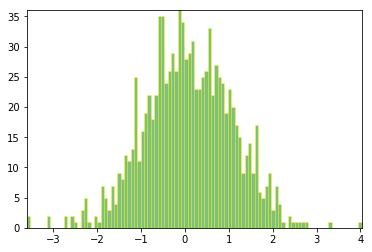

In [56]:
import matplotlib.patches as patches
import matplotlib.path as path

fig = plt.figure()
ax = fig.add_subplot(111)

# Fixing random state for reproducibility
np.random.seed(19680801)

# histogram our data with numpy
data = np.random.randn(1000)
n, bins = np.histogram(data, 100)

# get the corners of the rectangles for the histogram
left = np.array(bins[:-1])
right = np.array(bins[1:])
bottom = np.zeros(len(left))
top = bottom + n
nrects = len(left)

nverts = nrects*(1+3+1)
verts = np.zeros((nverts, 2))
codes = np.ones(nverts, int) * path.Path.LINETO
codes[0::5] = path.Path.MOVETO
codes[4::5] = path.Path.CLOSEPOLY
verts[0::5,0] = left
verts[0::5,1] = bottom
verts[1::5,0] = left
verts[1::5,1] = top
verts[2::5,0] = right
verts[2::5,1] = top
verts[3::5,0] = right
verts[3::5,1] = bottom

barpath = path.Path(verts, codes)
patch = patches.PathPatch(barpath, facecolor='green', edgecolor='yellow', alpha=0.5)
ax.add_patch(patch)

ax.set_xlim(left[0], right[-1])
ax.set_ylim(bottom.min(), top.max())

plt.show()

## Path effects guide
http://matplotlib.org/users/patheffects_guide.html

Matplotlib’s patheffects module provides functionality to apply a multiple draw stage to any Artist which can be rendered via a Path.

Artists which can have a path effect applied to them include Patch, Line2D, Collection and even Text. Each artist’s path effects can be controlled via the set_path_effects method (***set_path_effects***), which takes an iterable of ***AbstractPathEffect*** instances.

The simplest path effect is the ***Normal*** effect, which simply draws the artist without any effect:

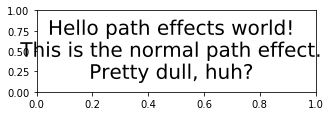

In [64]:
import matplotlib.patheffects as path_effects

fig = plt.figure(figsize=(5, 1.5))
ax = plt.subplot()

text = fig.text(0.5, 0.5, 'Hello path effects world!\nThis is the normal '
                          'path effect.\nPretty dull, huh?',
                ha='center', va='center', size=20)

text.set_path_effects([path_effects.Normal()])

plt.show()

Whilst the plot doesn’t look any different to what you would expect without any path effects, the drawing of the text now been changed to use the path effects framework, opening up the possibilities for more interesting examples.

### Adding a shadow

A far more interesting path effect than Normal is the drop-shadow, which we can apply to any of our path based artists. The classes ***SimplePatchShadow*** and ***SimpleLineShadow*** do precisely this by drawing either a filled patch or a line patch below the original artist:

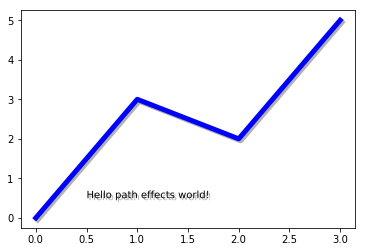

In [60]:
import matplotlib.patheffects as path_effects

text = plt.text(0.5, 0.5, 'Hello path effects world!',
                path_effects=[path_effects.withSimplePatchShadow()])

plt.plot([0, 3, 2, 5], linewidth=5, color='blue',
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.show()

Notice the two approaches to setting the path effects in this example. The first uses the with* classes to include the desired functionality automatically followed with the “normal” effect, whereas the latter explicitly defines the two path effects to draw.

### Making an artist stand out

One nice way of making artists visually stand out is to draw an outline in a bold color below the actual artist. The ***Stroke*** path effect makes this a relatively simple task:

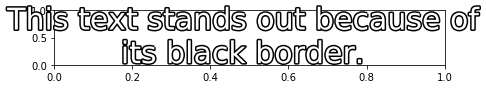

In [65]:
import matplotlib.patheffects as path_effects

fig = plt.figure(figsize=(7, 1))
ax = plt.subplot()

text = fig.text(0.5, 0.5, 'This text stands out because of\n'
                          'its black border.', color='white',
                          ha='center', va='center', size=30)

text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])
plt.show()


It is important to note that this effect only works because we have drawn the text path twice; once with a thick black line, and then once with the original text path on top.

You may have noticed that the keywords to ***Stroke*** and ***SimplePatchShadow*** and ***SimpleLineShadow*** are not the usual Artist keywords (such as facecolor and edgecolor etc.). This is because with these path effects we are operating at lower level of matplotlib. In fact, the keywords which are accepted are those for a ***matplotlib.backend_bases.GraphicsContextBase*** instance, which have been designed for making it easy to create new backends - and not for its user interface.

### Greater control of the path effect artist

As already mentioned, some of the path effects operate at a lower level than most users will be used to, meaning that setting keywords such as facecolor and edgecolor raise an AttributeError. Luckily there is a generic PathPatchEffect path effect which creates a PathPatch class with the original path. The keywords to this effect are identical to those of PathPatch:

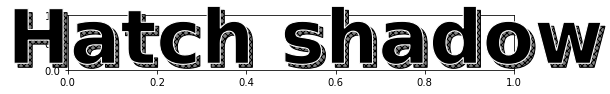

In [67]:
import matplotlib.patheffects as path_effects

fig = plt.figure(figsize=(8, 1))
ax = plt.subplot()

t = fig.text(0.02, 0.5, 'Hatch shadow', fontsize=75, weight=1000, va='center')
t.set_path_effects([path_effects.PathPatchEffect(offset=(4, -4), hatch='xxxx',
                                                  facecolor='gray'),
                    path_effects.PathPatchEffect(edgecolor='white', linewidth=1.1,
                                                 facecolor='black')])
plt.show()